In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
image = np.matrix(Image.open("ocr_sample.png").convert("L"))

In [ ]:
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

In [3]:
import scipy.ndimage
import math

def preprocess(image):
    image2 = 255-image
    
    edges = cv2.Canny(image2, 50, 150, 3)
    lines = cv2.HoughLinesP(edges, 0.1, np.pi/720, 73, 6, 6)
    
    th = 0
    nth = 0
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        theta = math.atan2(y2-y1,x2-x1)
        nth+=1
        th += theta
        
    theta = th/nth
        
    return ndimage.rotate(image2, np.degrees(theta), reshape=False)

In [4]:
plt.imshow(preprocess(image), cmap=plt.cm.gray)
plt.show()

NameError: name 'image' is not defined

In [49]:
readyImage = preprocess(image)

In [50]:
from PIL import ImageFont
from PIL import ImageDraw

In [57]:
fontDictionary = {}
glyphs = [chr(x) for x in range(ord("a"), ord("z")+1)] \
    + [chr(x) for x in range(ord("0"), ord("9")+1)] \
    + [".", ",", "!", "?"]

In [90]:
font = ImageFont.truetype("LiberationSans-Regular.ttf", size = 82)

In [91]:
letter = Image.new('L', font.getsize("t"), 255)

In [92]:
draw = ImageDraw.Draw(letter)

In [93]:
draw.text((0,0), "t", font=font)

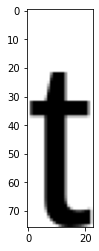

In [94]:
plt.imshow(letter, cmap=plt.cm.gray)
plt.show()

In [105]:
def loadLetter(letter, font, size=82):
    letterImage = Image.new('L', font.getsize(letter), 255)
    draw = ImageDraw.Draw(letterImage)
    draw.text((0,0), letter, font=font)
    return 255-np.matrix(letterImage)

In [106]:
for glyph in glyphs:
    fontDictionary[glyph] = loadLetter(glyph, font)

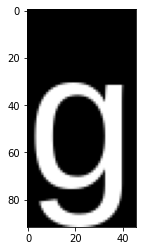

In [107]:
plt.imshow(fontDictionary["g"], cmap=plt.cm.gray)
plt.show()

In [115]:
contours, _ = cv2.findContours(readyImage, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_NONE)
len(contours)

2324

In [123]:
def contourBounding(contour, margin = 30):
    if len(contour) < 4:
        None
    else:
        lowerLeft  = (contour[0][0,0], contour[0][0,1])
        upperRight = lowerLeft
        for entry in contour:
            px = entry[0,0]
            py = entry[0,1]
            if px < lowerLeft[0]:
                lowerLeft = (px, lowerLeft[1])
            if px > upperRight[0]:
                upperRight = (px, upperRight[1])
            if py > lowerLeft[1]:
                lowerLeft = (lowerLeft[0], py)
            if py < upperRight[1]:
                upperRight = (upperRight[0], py)
        
        if abs(lowerLeft[0]-upperRight[0])*abs(lowerLeft[1]-upperRight[1]) < margin:
            return None
                
        return (lowerLeft, upperRight)

In [124]:
boundingBoxes = []

for contour in contours:
    bb = contourBounding(contour)
    if bb != None:
        boundingBoxes.append(bb)
        
print(len(boundingBoxes))

332


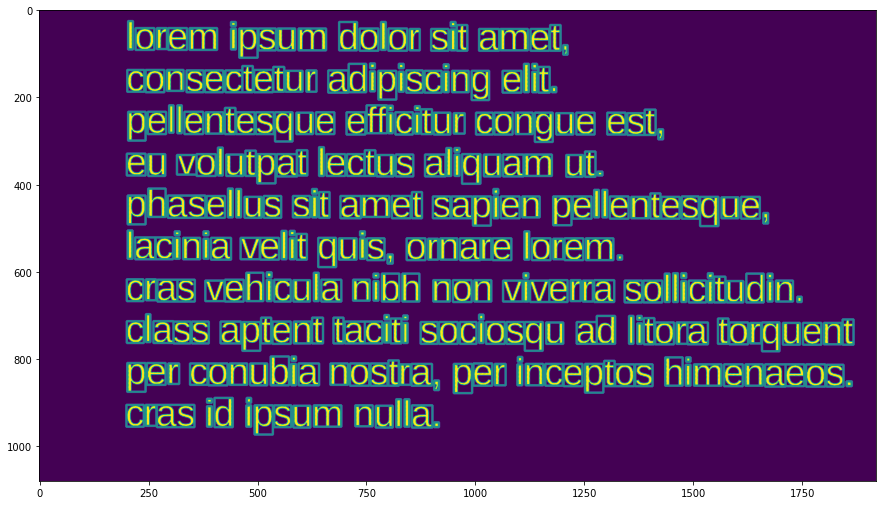

In [127]:
o = readyImage.copy()
for bbox in boundingBoxes:
    cv2.rectangle(o, pt1=bbox[0], pt2=bbox[1], color=120, thickness=3)
plt.figure(figsize=(15,9))
plt.imshow(o)
plt.show()

In [136]:
def detectLines(image):
    meanMatrix = np.mean(image, axis=1)
    
    line_start = -1
    
    lines = []
    
    for vindex in range(len(meanMatrix)):
        matrixValue = meanMatrix[vindex]
        
        if matrixValue > 0 and line_start == -1:
            line_start = vindex
        if matrixValue == 0 and line_start != -1:
            lines.append((line_start, vindex-1))
            line_start = -1
            
    return lines

In [164]:
lines = detectLines(readyImage)
lines

[(25, 109),
 (122, 207),
 (217, 303),
 (313, 399),
 (409, 496),
 (505, 590),
 (601, 671),
 (697, 784),
 (793, 879),
 (889, 974)]

In [152]:
def correlation(image_1, image_2):
    return np.real(
        np.fft.ifft2(
            np.multiply(
                np.fft.fft2(image_1),
                np.fft.fft2(np.rot90(image_2, 2))
            )
        )
    )

def detectLetter(letterSlice, fontDict):
    xSize, ySize = letterSlice.shape[1], letterSlice.shape[0]
    for letterImage in fontDict.values():
        xSize = max(xSize, letterImage.shape[1])
        ySize = max(ySize, letterImage.shape[0])
    xSize, ySize = xSize*2, ySize*2
    image_hat = np.zeros((ySize, xSize))
    image_hat[:letterSlice.shape[0],:letterSlice.shape[1]] = letterSlice
    
    maxLetter, maxScore = None, -float("inf")
    
    for letter, letterImage in fontDict.items():
        pattern_hat = np.zeros_like(image_hat)
        pattern_hat[:letterImage.shape[0], :letterImage.shape[1]] = letterImage
        corr = correlation(image_hat-125, pattern_hat-125)
        score = np.amax(corr)
        if score > maxScore:
            maxLetter = letter
            maxScore = score
            
    return maxLetter

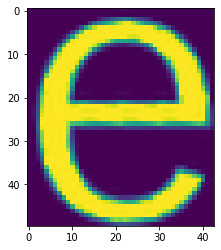

'e'

In [163]:
sampleBbox = boundingBoxes[23]
imageSlice = readyImage[sampleBbox[1][1]:sampleBbox[0][1],sampleBbox[0][0]:sampleBbox[1][0]]
plt.imshow(imageSlice)
plt.show()
detectLetter(imageSlice, fontDictionary)

In [181]:
linesLetters = [[] for _ in range(len(lines))]

for bbox in boundingBoxes:
    for lidx, l in enumerate(lines):
        yavg = (bbox[1][1]+bbox[0][1])/2
        if yavg > l[0] and yavg < l[1]:
            imageSlice = readyImage[bbox[1][1]:bbox[0][1],bbox[0][0]:bbox[1][0]]
            detectedLetter = detectLetter(imageSlice, fontDictionary)    
            if detectedLetter == ".":
                imageSlice = readyImage[bbox[1][1]:bbox[0][1]+60,bbox[0][0]:bbox[1][0]]
                detectedLetter2 = detectLetter(imageSlice, fontDictionary)   
                if detectedLetter2 == "i" or detectedLetter2 == "j":
                    continue
            linesLetters[lidx].append((bbox[0][0], bbox[1][0], detectedLetter))
            break
    

In [182]:
linesSorted = [sorted(line) for line in linesLetters]

In [183]:
maxBoundDistance = 0

for line in linesSorted:
    if len(line) == 0:
        continue
    lastRight = line[0][0]
    for left, right, letter in line:
        if left - lastRight > maxBoundDistance:
            maxBoundDistance = left - lastRight
        lastRight = right

spacingDistance = maxBoundDistance*0.5

In [184]:
output = ""
for line in linesSorted:
    if len(line) == 0:
        continue
    lastRight = line[0][0]
    for left, right, letter in line:
        if left - lastRight > spacingDistance:
            output += " "
        output += letter
        lastRight = right
    output += "\n"

In [185]:
print(output)

lorem ipsum dolor sit amet,
consectetur adipiscing elit.
pellentesque eficitur congue est,
eu volutpat lectus aliquam ut.
phaellus sit amet sapien pellentesque,
lacinia velit quis, ornare lorem.
cras vehicula nibh non viverra sollicitudin.
class aptent taciti sociosqu ad litora torquent
per conubia nostra, per inceptos himenaeos.
cra id ipsum nulla.

